## Predicting labels from stackoverflow comments using Keras 

***Francisca Dias***

## Table of Contents

* [Introduction](#Introduction)



* [Processing features in Keras](#ProcessingfeaturesinKeras)



* [Processing labels in Keras](#ProcessinglabelsinKeras)



* [Build the model](#Buildthemodel)



* [Predicitions on real examples](#Predicitionsonrealexamples)

## <a id='Introduction'>Introduction</a>

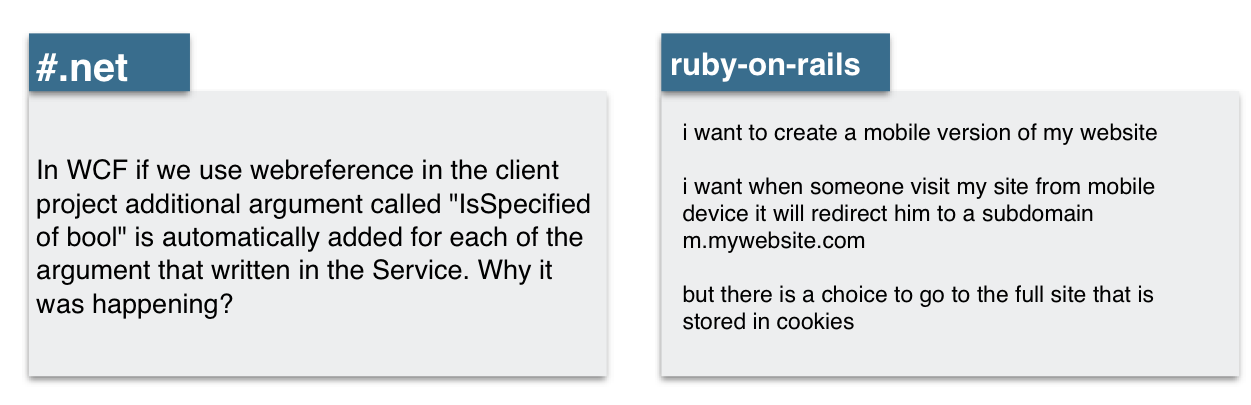

In [1]:
from IPython.display import Image
Image("stack_overflow.png")

Above are two questions that were asked on Stack Overflow. The first has a tag #.net and the second one is related to ruby-on-rails.

In this report I will build a model that can predict the tag on new questions on Stack Overflow.

In this dataset there are 20 tags. 

Each tag corresponds to a **programming language** or a **topic** related to technology: 

**c#, python, css, javascript, androind, iphone, ios, etc.**

This dataset can be found [here.](https://github.com/franciscadias/data/blob/master/stack-overflow-data.csv)

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("stack-overflow-data.csv")

In [4]:
data.head()

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python


**How many instances our data has?**

In [5]:
len(data)

40000

**Split data into train and test**

In [6]:
train_size = int(len(data) * .8)
print(train_size)

32000


In [7]:
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 32000
Test size: 8000


In [8]:
train_comments = data['post'][:train_size]
train_labels = data['tags'][:train_size]

test_comments = data['post'][train_size:]
test_labels = data['tags'][train_size:]

In [9]:
print(train_comments.shape)
print(train_labels.shape)
print(test_comments.shape)
print(test_labels.shape)

(32000,)
(32000,)
(8000,)
(8000,)


## <a id='ProcessingfeaturesinKeras'>Processing features in Keras</a>

** We have to process our features in a format that Keras can read**

In [10]:
from keras.preprocessing import text

max_words = 1000
t = text.Tokenizer(num_words=max_words, char_level=False)

Using TensorFlow backend.
/Users/FranciscaDias/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


**Fit on train data**

In [11]:
t.fit_on_texts(train_comments)

**There are 129402 distinct words on X_train**

In [12]:
print("There are %d" % len(t.word_counts), "distinct words on X_train")
print("In: %d" %t.document_count, "documents or instances")

There are 129402 distinct words on X_train
In: 32000 documents or instances


**Documents have to be encoded using the Tokenizer by calling texts to matrix()**

In [13]:
X_train = t.texts_to_matrix(train_comments)
X_test = t.texts_to_matrix(test_labels)

## <a id='ProcessinglabelsinKeras'>Processing labels in Keras</a>

**Use LabelBinarizer class to convert label strings to numbered**

In [14]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train_labels)
y_train = encoder.transform(train_labels)
y_test = encoder.transform(test_labels)

In [15]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (32000, 1000)
X_test shape: (8000, 1000)
y_train shape: (32000,)
y_test shape: (8000,)


**Now let us convert the labels to a one-hot representation**

In [16]:
# Converts the labels to a one-hot representation
import numpy as np
from keras import utils

num_classes = np.max(y_train) + 1

y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [17]:
print('x_train shape:', X_train.shape)
print('x_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (32000, 1000)
x_test shape: (8000, 1000)
y_train shape: (32000, 20)
y_test shape: (8000, 20)


#### With our features and labels in a format Keras can read, we’re ready to build our text classification model.

## <a id='Buildthemodel'>Build the model</a>

In [18]:
from keras.models import Sequential

model = Sequential()

In [19]:
from keras.layers import Dense, Activation, Dropout

max_words = 1000

model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

Now we’re ready to add our input layer, that is called Dense layer, which means each neuron in this layer will be fully connected to all neurons in the next layer. 

We pass the Dense layer two parameters: 

* 1- the dimensionality of the layer’s output (number of neurons): It’s common to use a power of 2 as the number of dimensions, so we’ll start with 512.

* 2- the shape of our input data: max_words (equals 1000) arrays for each comment



The number of rows in our input data will be the number of posts we’re feeding the model at each training step (called batch size), 


and the number of columns will be the size of our vocabulary. 


With that, we’re ready to define the Dense input layer. 

The activation function tells our model how to calculate the output of a layer (you can read more about ReLU here).

In [20]:
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=2, 
                    verbose=1, 
                    validation_split=0.1)

Train on 28800 samples, validate on 3200 samples
Epoch 1/2
28800/28800 [==============================] - 14s 485us/step - loss: 0.9758 - acc: 0.7166 - val_loss: 0.6184 - val_acc: 0.8053
Epoch 2/2
28800/28800 [==============================] - 11s 392us/step - loss: 0.5531 - acc: 0.8261 - val_loss: 0.5976 - val_acc: 0.8050


**Evaluate the model**

In [21]:
score = model.evaluate(X_test, y_test, 
                       batch_size=32, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

8000/8000 [==============================] - 1s 95us/step
Test score: 0.44437707907
Test accuracy: 0.90175


## <a id='Predicitionsonrealexamples'>Predicitions on real examples</a>

**Lets make predicitions on real examples**

Remember that test_comments contained all the comments text:

In [22]:
test_comments.head()

32000    jquery( tr_selector ) is removing the style va...
32001    web reference in wcf  in wcf if we use webrefe...
32002    fragment transaction custom animation - androi...
32003    why can i not use the namespace directive in c...
32004    generating password reset link in c# .net  i m...
Name: post, dtype: object

**Let us see how well the model predicts the first five comments**

Let´s make predicitions on new data, that is, on test data, for the first 5 comments:

In [23]:
for i in range(5):
    prediction = model.predict(np.array([X_test[i]]))
    predicted_label = encoder.classes_[np.argmax(prediction)]
    print(test_comments.iloc[i][:50], "...")
    print('Actual label:' + test_labels.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

jquery( tr_selector ) is removing the style values ...
Actual label:jquery
Predicted label: jquery

web reference in wcf  in wcf if we use webreferenc ...
Actual label:.net
Predicted label: .net

fragment transaction custom animation - android  i ...
Actual label:android
Predicted label: android

why can i not use the namespace directive in c++ s ...
Actual label:c++
Predicted label: c#

generating password reset link in c# .net  i must  ...
Actual label:.net
Predicted label: .net



**It looks like in 5 questions we only missed one. The fourth question is related to c++ but the model predicted c#.**